In [1]:
import torch
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
import numpy as np
import torchvision.datasets as datasets
from torchvision import transforms
import random
import cv2
from PIL import Image
from torch.nn import MSELoss
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

In [2]:
config = {
    'batch_size':32
}

In [3]:
new_model = torch.load('cifar100.pth')

In [4]:
feature_ext = create_feature_extractor(new_model, return_nodes={'layer3.5.relu_1':'layer3.5.relu_1'})

In [5]:
inp = np.random.rand(2,3,32,32)
feature_ext(torch.Tensor(inp).to('cuda'))['layer3.5.relu_1'].shape

torch.Size([2, 256, 2, 2])

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
cifar10_trainset = datasets.CIFAR10(root='/home/user01/cifar10/train/', train=True,
                                    download=False, transform=transform_train)
cifar10_testset = datasets.CIFAR10(root='/home/user01/cifar10/test/', train=False,
                                   download=False, transform=transform_test)
trainloader = torch.utils.data.DataLoader(
    cifar10_trainset, batch_size=config['batch_size'], shuffle=True, num_workers=7)
testloader = torch.utils.data.DataLoader(
    cifar10_testset, batch_size=config['batch_size'], shuffle=False, num_workers=7)

In [7]:
trigger = cv2.resize(cv2.imread('/home/user01/htbd-new.png'),(5,5))
def combine(img):
    result = img.copy()
    x_offset = random.randint(5,20)
    y_offset = random.randint(5,20)
    result[y_offset:y_offset+trigger.shape[0], x_offset:x_offset+trigger.shape[1]] = trigger
    return result

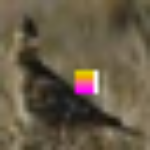

In [8]:
rnd_idx = random.randint(1,cifar10_trainset.data.shape[0])
res = combine(cifar10_trainset.data[rnd_idx])
Image.fromarray(cv2.resize(res, (150,150))).show()

In [9]:
four_indices = set([idx for idx,target in enumerate(cifar10_trainset.targets) if target==4])
chosen_four_images = cifar10_trainset.data[random.sample(four_indices, 100)].copy()
five_indices = set([idx for idx,target in enumerate(cifar10_trainset.targets) if target==5])
chosen_five_images = cifar10_trainset.data[random.sample(five_indices, 100)].copy().transpose(0,3,1,2)
triggered_images = np.array([combine(img) for img in chosen_four_images])
triggered_img_features = feature_ext(torch.Tensor(triggered_images.transpose(0,3,1,2))
                                     .to('cuda'))['layer3.5.relu_1'].cpu().detach().numpy()

/tmp/ipykernel_46472/2473480654.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  chosen_four_images = cifar10_trainset.data[random.sample(four_indices, 100)].copy()
/tmp/ipykernel_46472/2473480654.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  chosen_five_images = cifar10_trainset.data[random.sample(five_indices, 100)].copy().transpose(0,3,1,2)


In [10]:
triggered_img_features.shape

(100, 256, 2, 2)

In [11]:
chosen_five_images.shape

(100, 3, 32, 32)

In [12]:
class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self, chosen_images):
        
        super().__init__()
        # initialize weights with random numbers
        images = torch.Tensor(chosen_images)
        # make weights torch parameters
        self.images = nn.Parameter(images)        
        
    def forward(self, X):
        return ((feature_ext(self.images)['layer3.5.relu_1']
                -feature_ext(X)['layer3.5.relu_1'])**2).sum()

In [13]:
my_model = Model(chosen_five_images)
my_model = my_model.to('cuda')

In [14]:
my_model(torch.Tensor(triggered_images.transpose(0,3,1,2)).to('cuda'))

tensor(8676.4238, device='cuda:0', grad_fn=<SumBackward0>)

In [15]:
my_model.images.shape

torch.Size([100, 3, 32, 32])

In [16]:
opt = torch.optim.SGD(my_model.parameters(), lr=1)

In [17]:
def training_loop(model, optimizer, n=1000):
    "Training loop for torch model."
    losses = []
    for i in range(n):
        loss = model(torch.Tensor(triggered_images.transpose(0,3,1,2)).to('cuda'))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss)
        print(f'\r epoch {i} - loss:{loss}', end='')
    return losses 

In [18]:
# result = training_loop(my_model, opt, 500)

In [19]:
my_model = Model(torch.Tensor(chosen_five_images))
my_model = my_model.to('cuda')
opt = torch.optim.SGD(my_model.parameters(), lr=1)
for i in range(10):
    result = training_loop(my_model, opt, 500)
    clamped_images = torch.clamp(my_model.images,
                                 min=torch.Tensor(chosen_five_images).to('cuda')-16,
            max=torch.Tensor(chosen_five_images).to('cuda')+16).cpu().detach().numpy()
    if i != 9:
        my_model = Model(torch.Tensor(clamped_images))
        my_model = my_model.to('cuda')
        opt = torch.optim.SGD(my_model.parameters(), lr=1)

 epoch 499 - loss:4100.47851562525

In [ ]:
Image.fromarray(cv2.resize(chosen_five_images[15].transpose(2,1,0), (150,150)))

In [ ]:
img = np.uint8(my_model.images[15].cpu().detach().numpy().transpose(2,1,0))
img = cv2.resize(img, (150,150))
Image.fromarray(img)

In [ ]:
Image.fromarray(np.uint8(torch.clamp(torch.Tensor(img), 0, 255).numpy()))

In [ ]:
clamped_images = torch.clamp(my_model.images, min=torch.Tensor(chosen_five_images).to('cuda')-5,
            max=torch.Tensor(chosen_five_images).to('cuda')+5).cpu().detach().numpy()

In [ ]:
Image.fromarray(cv2.resize(np.uint8(clamped_images[5].transpose(2,1,0)), (150,150)))